In [29]:
import torch
import torch.nn as nn 
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [30]:
def load_data(batch_size=32):
    transform = transforms.Compose([
        transforms.ToTensor(), # Convert images to PyTorch tensors
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) # Normalize to [-1, 1]
    ])
    
    train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform,
    download=True)
    test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform,
    download=True)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

In [31]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(64 * 8 * 8, 128),  
            nn.ReLU(),                  
            nn.Linear(128, 10),        
            nn.Softmax(dim=1)          
        )

    def forward(self, x):
        x = self.features(x) 
        x = torch.flatten(x, 1)
        x = self.classifier(x) 

        return x 

In [32]:
train_loader, test_loader = load_data()

Files already downloaded and verified
Files already downloaded and verified


In [33]:
# Example code snippet from the lesson
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_per_epoch = []
val_loss_per_epoch = []

all_preds = []
all_labels = []
all_probs = [] 

for epoch in range(10):
    running_loss = 0.0
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    mean_loss = running_loss / len(train_loader)
    loss_per_epoch.append(mean_loss) 

    model.eval() 
    val_running_loss = 0.0
    with torch.no_grad():  
        for val_images, val_labels in test_loader:
            _, predicted = torch.max(outputs.data, 1)
            val_outputs = model(val_images)

            probs = torch.nn.functional.softmax(outputs, dim=1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()

    val_mean_loss = val_running_loss / len(test_loader)
    val_loss_per_epoch.append(val_mean_loss)

    print(f"Epoch {epoch+1}, Training Loss: {mean_loss:.4f}, Validation Loss: {val_mean_loss:.4f}")

Epoch 1, Training Loss: 2.0397, Validation Loss: 1.9647
Epoch 2, Training Loss: 1.9197, Validation Loss: 1.8915
Epoch 3, Training Loss: 1.8631, Validation Loss: 1.8617
Epoch 4, Training Loss: 1.8300, Validation Loss: 1.8415
Epoch 5, Training Loss: 1.8006, Validation Loss: 1.8267
Epoch 6, Training Loss: 1.7796, Validation Loss: 1.8119
Epoch 7, Training Loss: 1.7661, Validation Loss: 1.8173
Epoch 8, Training Loss: 1.7449, Validation Loss: 1.7899
Epoch 9, Training Loss: 1.7299, Validation Loss: 1.7907
Epoch 10, Training Loss: 1.7188, Validation Loss: 1.7906


<Axes: >

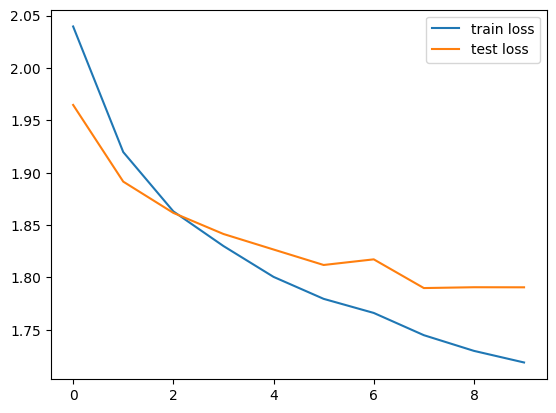

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings(action="ignore")

sns.lineplot(x=range(10), y=loss_per_epoch, label="train loss")
sns.lineplot(x=range(10), y=val_loss_per_epoch, label="test loss")

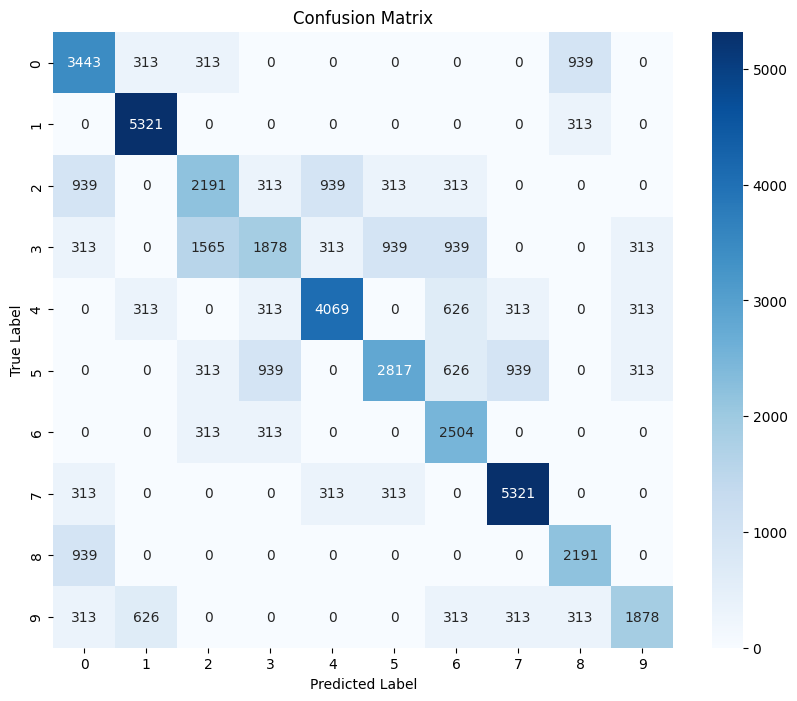

In [35]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [36]:
for i in range(6): 
    print(f"Prediction: {all_preds[i]}, Label: {all_labels[i]}, Probabilities: {all_probs[i]}")

Prediction: 6, Label: 4, Probabilities: [0.08957526 0.08957477 0.10890101 0.09041007 0.11159799 0.10315523
 0.13764946 0.08998865 0.0895738  0.08957385]
Prediction: 7, Label: 7, Probabilities: [0.08536711 0.08536833 0.08536667 0.08536672 0.08538724 0.08537509
 0.08553999 0.23149553 0.08536665 0.08536666]
Prediction: 4, Label: 4, Probabilities: [0.08831689 0.0871809  0.09970988 0.08718012 0.1995331  0.08718014
 0.08739393 0.08914499 0.08718007 0.08718006]
Prediction: 2, Label: 2, Probabilities: [0.0874856  0.08673518 0.20799574 0.08761746 0.08673605 0.09646802
 0.08673518 0.08673518 0.08675636 0.08673518]
Prediction: 5, Label: 5, Probabilities: [0.0853368  0.0853368  0.0853368  0.0853371  0.0853368  0.23196828
 0.0853368  0.08533693 0.0853368  0.0853368 ]
Prediction: 4, Label: 3, Probabilities: [0.08821601 0.08821597 0.12463224 0.08821833 0.16954248 0.08830964
 0.08821702 0.08821635 0.08821597 0.08821597]
